In [2]:
import cv2
import os
import numpy as np
import skimage.feature
import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle 
import pickle
import csv 
%matplotlib inline

In [3]:
import keras
from keras.models import Sequential, load_model
from keras.models import Model
from keras.layers import Input, concatenate, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.


In [4]:
print (os.getcwd())

/home/ubuntu/pynb/noaa-sealions


In [5]:
train_path = "/home/ubuntu/pynb/noaa-sealions/data/Train/"
train_dotted_path = "/home/ubuntu/pynb/noaa-sealions/data/TrainDotted/"
train_blob_path = "/home/ubuntu/pynb/noaa-sealions/data/TrainBlob/"
file_names = os.listdir(train_path)

In [6]:
def filter_image_files(file_names):
    for f in file_names: 
        if f.endswith('.jpg'):
            pass
        else:
            file_names.remove(f) 
            
filter_image_files(file_names)

### Sample Images

(3744, 5616, 3)


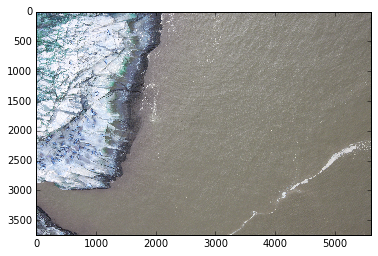

In [7]:
img = cv2.imread(train_path + file_names[0])
print (img.shape)
plt.imshow(img)
plt.show()

In [8]:
# 3328, 4992, 3
def normalize(x): 
    return (x - float(np.min(x))) / (float(np.max(x)) - float(np.min(x)))

In [9]:
def resize_1(img, size): 
    return cv2.resize(img, size) 

def resize_2(img, fx, fy): 
    return cv2.resize(img, None, fx=fx, fy=fy) 

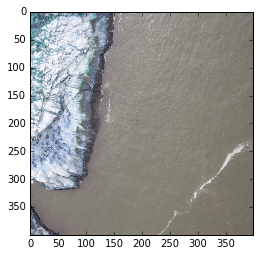

(400, 400, 3)


In [10]:
file_name = file_names[0]
img_1 = cv2.imread(train_path + file_name)
img_1 = resize_1(img_1, (400,400))
plt.imshow(img_1)
plt.show()
print (img_1.shape)

In [11]:
# def preprocess_and_save(train_path, train_blob_path): 
def preprocess(train_path, train_blob_path): 
    
    file_names = os.listdir(train_path)
    filter_image_files(file_names)
    shuffle(file_names)

    counts = dict()
    with open(train_path + 'train.csv') as csvfile: 
        next(csvfile) 
        reader = csv.reader(csvfile)
        for row in reader: 
            counts[int(row[0])] = row[1:]

    y = []
    for f in file_names: 
        name,ext = f.split('.')
        y.append(counts[int(name)])
    y = np.array(y,dtype=np.int)  
    
    
    validation_count = int(len(file_names) * 0.1) 
    
    x = [] 
    
    for f in file_names: 
        img_1 = cv2.imread(train_path + f)
        x.append(resize_1(img_1, (400,400)))
                
    x = np.array(x)
    x = normalize(x)
                
    train_x = x[:-validation_count]
    train_y = y[:-validation_count]
    valid_x = x[-validation_count:]
    valid_y = y[-validation_count:]
    
#     from sys import platform
#     if platform != 'darwin': #OSError in MAC
#         pickle.dump((train_x, train_y), open('train.p', 'wb'))
#         pickle.dump((valid_x, valid_y), open('valid.p', 'wb'))

    return (train_x, train_y, valid_x, valid_y)

In [12]:
train_x, train_y, valid_x, valid_y = preprocess(train_path, train_blob_path)

In [13]:
print (len(train_x))
print (len(train_y))
print (len(valid_x))
print (len(valid_x))

854
854
94
94


### Neural Network

In [ ]:
img_rows = 400 
img_cols = 400 
img_depth = 3

inputs = Input((img_rows, img_cols, img_depth))

conv1 = Conv2D(  8, (10, 10), activation='relu', padding='same')(inputs)
conv1 = Conv2D(  8, (10, 10), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D( 64, (10, 10), activation='relu', padding='same')(pool1)
conv2 = Conv2D( 64, (10, 10), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (10, 10), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (10, 10), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (10, 10), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (10, 10), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (10, 10), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (10, 10), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (5, 5), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (5, 5), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (5, 5), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (5, 5), activation='relu', padding='same')(conv7)

# up8 = concatenate([Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
# conv8 = Conv2D( 64, (5, 5), activation='relu', padding='same')(up8)
# conv8 = Conv2D( 64, (5, 5), activation='relu', padding='same')(conv8)

# up9 = concatenate([Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
# conv9 = Conv2D( 32, (5, 5), activation='relu', padding='same')(up9)
# conv9 = Conv2D( 32, (5, 5), activation='relu', padding='same')(conv9)

conv10 = Flatten()(conv7)

conv11 = Dense(64, activation='relu' ) (conv10)
conv12 = Dense(5, activation='linear') (conv10)

model = Model(inputs=[inputs], outputs=[conv12])
model.compile(optimizer=optimizers.Adam(lr=1e-3), loss='mse', metrics=['accuracy'])    


In [ ]:
model.fit(train_x, train_y, batch_size=4, epochs=50, verbose=2)

Epoch 1/50
348s - loss: 1157685.3204 - acc: 0.4602
Epoch 2/50
333s - loss: 1779.6203 - acc: 0.4778
Epoch 3/50
333s - loss: 1787.8326 - acc: 0.4778
Epoch 4/50


In [ ]:
score = model.evaluate(valid_x, valid_y, batch_size=1)

In [ ]:
score

In [ ]:
test_path = "/home/ubuntu/pynb/noaa-sealions/data/Test/"
file_names = os.listdir(test_path)
print (len(file_names)) 

In [ ]:

header = tuple(['test_id','adult_males','subadult_males','adult_females','juveniles','pups'])
with open('submission.csv', 'wt') as csvfile:
    csvwriter = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(header)
    for f in file_names: 
        try: 
            tid, text = f.split('.')
            x = []
            img = cv2.imread(test_path + f)
            x.append(resize_1(img, (600,400))) 
            x = np.array(x) 
            vals = model.predict(x) 
            vals = vals[0].astype(np.int).tolist()
            
            for i in range(len(vals)): 
                if vals[i] < 0: 
                    vals[i] * -1
            
            res = tuple([int(tid)] + vals) 
            csvwriter.writerow(res)
        except Exception as e: 
            pass 
